In [62]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, GRU
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

## โหลดข้อมูลหุ้น BH.BK

In [63]:
ticker = 'BH.BK'
data = yf.download(ticker, start='2023-01-01', end='2025-01-01')
data = data[['Close']]

[*********************100%***********************]  1 of 1 completed


## Normalize ข้อมูล

In [64]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

## ฟังก์ชันสร้างชุดข้อมูล

In [65]:
def create_dataset(data, time_step=60):
    X, y = [], []
    for i in range(len(data) - time_step - 1):
        X.append(data[i:(i + time_step), 0])
        y.append(data[i + time_step, 0])
    return np.array(X), np.array(y)

## แบ่งข้อมูล Train-Test

In [66]:
train_size = int(len(scaled_data) * 0.8)
train_data, test_data = scaled_data[:train_size], scaled_data[train_size:]

time_step = 60
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

## แปลงรูปข้อมูลสำหรับ LSTM & GRU

In [67]:
X_train_lstm = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test_lstm = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

## โมเดล

In [68]:
# โมเดล 1: LSTM
model_lstm = Sequential([
    LSTM(50, return_sequences=True, input_shape=(time_step, 1)),
    LSTM(50, return_sequences=False),
    Dense(25),
    Dense(1)
])
model_lstm.compile(optimizer='adam', loss='mean_squared_error')
model_lstm.fit(X_train_lstm, y_train, batch_size=64, epochs=20, verbose=0)

# โมเดล 2: GRU
model_gru = Sequential([
    GRU(50, return_sequences=True, input_shape=(time_step, 1)),
    GRU(50, return_sequences=False),
    Dense(25),
    Dense(1)
])
model_gru.compile(optimizer='adam', loss='mean_squared_error')
model_gru.fit(X_train_lstm, y_train, batch_size=64, epochs=20, verbose=0)

# โมเดล 3: XGBoost
model_xgb = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100)
model_xgb.fit(X_train, y_train)

# โมเดล 4: Random Forest
model_rf = RandomForestRegressor(n_estimators=100)
model_rf.fit(X_train, y_train)

c:\Users\Lenovo\anaconda1\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


RandomForestRegressor()

## พยากรณ์ผลลัพธ์

In [69]:
y_pred_lstm = model_lstm.predict(X_test_lstm)
y_pred_gru = model_gru.predict(X_test_lstm)
y_pred_xgb = model_xgb.predict(X_test)
y_pred_rf = model_rf.predict(X_test)

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 328ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 429ms/step


## แปลงค่ากลับเป็นราคาหุ้นจริง

In [70]:
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))
y_pred_lstm_actual = scaler.inverse_transform(y_pred_lstm)
y_pred_gru_actual = scaler.inverse_transform(y_pred_gru)
y_pred_xgb_actual = scaler.inverse_transform(y_pred_xgb.reshape(-1, 1))
y_pred_rf_actual = scaler.inverse_transform(y_pred_rf.reshape(-1, 1))

## คำนวณค่าความแม่นยำ

In [72]:
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# คำนวณ MAPE
def calculate_mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# ประเมินผลโมเดล
def evaluate_model(y_true, y_pred, name):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = mean_squared_error(y_true, y_pred, squared=False)
    r2 = r2_score(y_true, y_pred)
    mape = calculate_mape(y_true, y_pred)  # คำนวณ MAPE
    accuracy = 100 - mape  # ความแม่นยำเป็นเปอร์เซ็นต์

    print(f" {name} Performance:")
    print(f"  MAE     = {mae:.4f}")
    print(f"  RMSE    = {rmse:.4f}")
    print(f"  R²      = {r2:.4f}")
    print(f"  Accuracy = {accuracy:.2f}%\n")
    
# เรียกใช้ฟังก์ชันเพื่อประเมินโมเดล
evaluate_model(y_test_actual, y_pred_lstm_actual, "LSTM")
evaluate_model(y_test_actual, y_pred_gru_actual, "GRU")
evaluate_model(y_test_actual, y_pred_xgb_actual, "XGBoost")
evaluate_model(y_test_actual, y_pred_rf_actual, "Random Forest")

 LSTM Performance:
  MAE     = 11.2832
  RMSE    = 15.0829
  R²      = 0.2696
  Accuracy = 94.61%

 GRU Performance:
  MAE     = 8.5845
  RMSE    = 11.1011
  R²      = 0.6044
  Accuracy = 95.90%

 XGBoost Performance:
  MAE     = 17.3485
  RMSE    = 18.7811
  R²      = -0.1324
  Accuracy = 91.48%

 Random Forest Performance:
  MAE     = 11.7549
  RMSE    = 13.3798
  R²      = 0.4253
  Accuracy = 94.25%



c:\Users\Lenovo\anaconda1\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\Lenovo\anaconda1\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\Lenovo\anaconda1\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\Lenovo\anaconda1\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use 

## แสดงกราฟเปรียบเทียบโมเดล

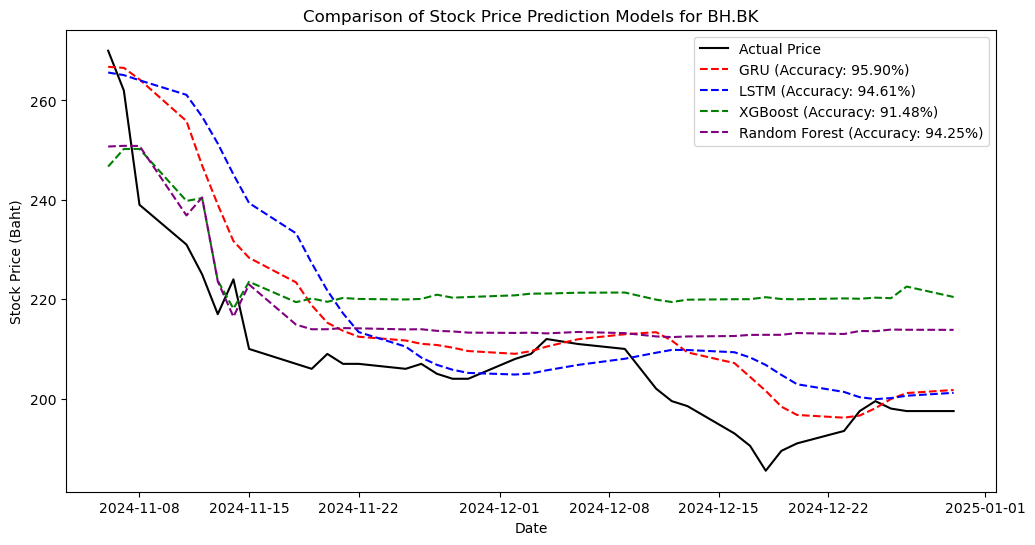

In [73]:
import numpy as np

# คำนวณ MAPE (Mean Absolute Percentage Error) สำหรับแต่ละโมเดล
def calculate_mape(actual, predicted):
    return np.mean(np.abs((actual - predicted) / actual)) * 100

# คำนวณ MAPE สำหรับแต่ละโมเดล
mape_gru = calculate_mape(y_test_actual, y_pred_gru_actual)
mape_lstm = calculate_mape(y_test_actual, y_pred_lstm_actual)
mape_xgb = calculate_mape(y_test_actual, y_pred_xgb_actual)
mape_rf = calculate_mape(y_test_actual, y_pred_rf_actual)

# คำนวณ accuracy โดยใช้ 100 - MAPE
accuracy_gru = 100 - mape_gru
accuracy_lstm = 100 - mape_lstm
accuracy_xgb = 100 - mape_xgb
accuracy_rf = 100 - mape_rf

# แสดงเปอร์เซ็นต์ในกราฟ
plt.figure(figsize=(12, 6))
plt.plot(data.index[-len(y_test_actual):], y_test_actual, label="Actual Price", color='black')
plt.plot(data.index[-len(y_pred_gru_actual):], y_pred_gru_actual, label=f"GRU (Accuracy: {accuracy_gru:.2f}%)", linestyle='dashed', color='red')
plt.plot(data.index[-len(y_pred_lstm_actual):], y_pred_lstm_actual, label=f"LSTM (Accuracy: {accuracy_lstm:.2f}%)", linestyle='dashed', color='blue')
plt.plot(data.index[-len(y_pred_xgb_actual):], y_pred_xgb_actual, label=f"XGBoost (Accuracy: {accuracy_xgb:.2f}%)", linestyle='dashed', color='green')
plt.plot(data.index[-len(y_pred_rf_actual):], y_pred_rf_actual, label=f"Random Forest (Accuracy: {accuracy_rf:.2f}%)", linestyle='dashed', color='purple')

plt.xlabel('Date')
plt.ylabel('Stock Price (Baht)')
plt.title(f'Comparison of Stock Price Prediction Models for {ticker}')
plt.legend()
plt.show()

## 1. การนำเข้าไลบรารี

In [74]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GRU

## 2. ดึงข้อมูลหุ้น

In [35]:
ticker = 'BH.BK'
data = yf.download(ticker, start='2023-01-01', end='2025-01-01')
data = data[['Close']]

[*********************100%***********************]  1 of 1 completed


## 3. การปรับขนาดข้อมูล

In [36]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

## 4. ฟังก์ชันสร้างชุดข้อมูล

In [37]:
def create_dataset(data, time_step=60):
    X, y = [], []
    for i in range(len(data) - time_step - 1):
        X.append(data[i:(i + time_step), 0])
        y.append(data[i + time_step, 0])
    return np.array(X), np.array(y)

## 5. แบ่งข้อมูลเป็น train และ test

In [38]:
train_size = int(len(scaled_data) * 0.8)
train_data, test_data = scaled_data[0:train_size, :], scaled_data[train_size:len(scaled_data), :]

## 6. การเตรียมข้อมูลสำหรับโมเดล

In [39]:
# Define the time_step (number of previous time steps to use for prediction)
time_step = 10  # You can adjust this depending on your dataset

# Create the dataset using the function
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

# Reshape the data if needed (for LSTM or RNN models)
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

## 7. การสร้างโมเดล GRU


In [40]:
model = Sequential()
model.add(GRU(50, return_sequences=True, input_shape=(time_step, 1)))
model.add(GRU(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

c:\Users\Lenovo\anaconda1\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


## 8. การคอมไพล์และเทรนโมเดล

In [41]:
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, batch_size=64, epochs=20, verbose=1)

Epoch 1/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.1610
Epoch 2/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0165
Epoch 3/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0143
Epoch 4/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0103
Epoch 5/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0084
Epoch 6/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0053
Epoch 7/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0050
Epoch 8/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0044
Epoch 9/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0045
Epoch 10/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0034
Epoch 11/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0030
Epoch 12/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0034
Epoch 13/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0027
Epoch 14/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0032
Epoch 15/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0027
Epoch 16/20
6/6 ━━━━━━━━━━━━━━━━━━

## 9. การทำนายผลลัพธ์

In [42]:
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)

12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


## 10. การพยากรณ์ในอนาคต

In [43]:
years_to_predict = 3
future_steps = 1095
last_data = scaled_data[-time_step:]
predictions = []

for _ in range(future_steps):
    input_data = last_data.reshape(1, time_step, 1)
    pred = model.predict(input_data)[0][0]
    predictions.append(pred)
    last_data = np.append(last_data[1:], pred).reshape(time_step, 1)

predictions = scaler.inverse_transform(np.array(predictions).reshape(-1, 1))
future_dates = pd.date_range(start=data.index[-1], periods=future_steps + 1)[1:]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━

## 11. การแสดงกราฟ

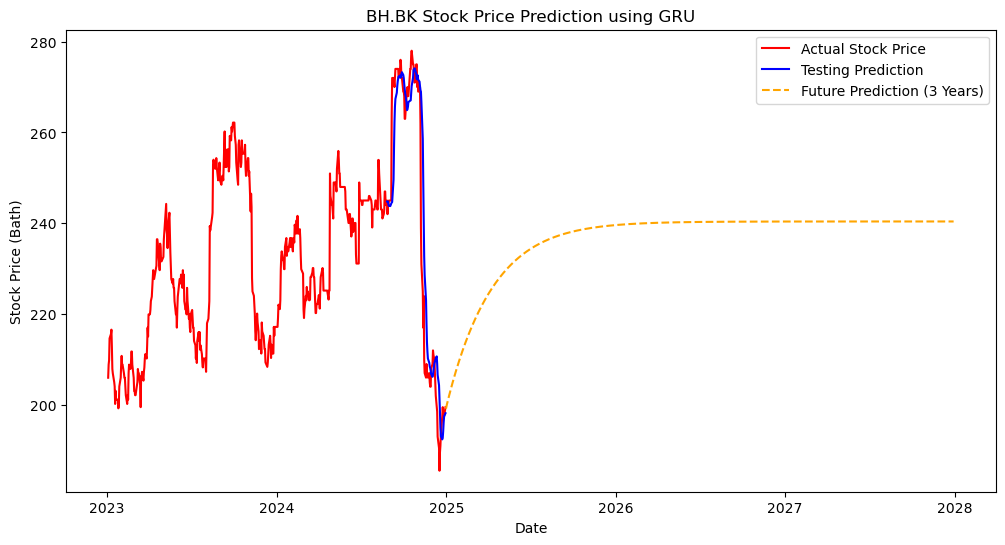

In [44]:
plt.figure(figsize=(12, 6))
plt.plot(data.index, scaler.inverse_transform(scaled_data), label='Actual Stock Price', color='red')
plt.plot(data.index[-len(test_predict):], test_predict, label='Testing Prediction', color='blue')
plt.plot(future_dates, predictions, label=f'Future Prediction ({years_to_predict} Years)', color='orange', linestyle='dashed')
plt.xlabel('Date')
plt.ylabel('Stock Price (Bath)')
plt.title(f'{ticker} Stock Price Prediction using GRU')
plt.legend()
plt.show()

## 12. การประเมินผลโมเดล

In [45]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

y_pred = model.predict(X_test)

y_test = np.array(y_test).reshape(-1, 1)
y_pred = np.array(y_pred).reshape(-1, 1)

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)
r2 = r2_score(y_test, y_pred)

print(f"MAE: {mae}")
print(f"MSE: {mse}")
print(f"RMSE: {rmse}")
print(f"R² Score: {r2}")

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
MAE: 0.05809629281028599
MSE: 0.008134643277309523
RMSE: 0.09019225730243989
R² Score: 0.931723071211025


c:\Users\Lenovo\anaconda1\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


## 13. การสร้าง DataFrame แสดงผลลัพธ์พยากรณ์

In [46]:
predicted_df = pd.DataFrame({
    "Date": future_dates,
    "Predicted Price": predictions.flatten()
})
predicted_df

,Date,Predicted Price
0,2024-12-31,199.161926
1,2025-01-01,199.666489
2,2025-01-02,200.111069
3,2025-01-03,200.537521
4,2025-01-04,200.951813
...,...,...
1090,2027-12-26,240.395218
1091,2027-12-27,240.395218
1092,2027-12-28,240.395218
1093,2027-12-29,240.395218
